# Import libraries

In [155]:
%matplotlib inline
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso, Ridge, LassoLars, BayesianRidge, ARDRegression, PassiveAggressiveRegressor
from sklearn.linear_model import HuberRegressor, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from collections import Counter
from pandas.api.types import is_numeric_dtype
from scipy.stats import randint
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from enum import Enum
import numpy as np
import random
from sklearn.utils import shuffle


# Load data

In [156]:


all_data = pd.read_csv("data.csv")
train_data = all_data[np.isnan(all_data["shot_made_flag"]) == False]
test_data = all_data[np.isnan(all_data["shot_made_flag"])]
train_data = shuffle(train_data)

y = train_data[y_column]
X = train_data.drop(labels=y_column, axis=1)
X_test = test_data



In [157]:
pd.set_option("display.max_columns",100)


In [158]:
train_data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
23953,Jump Shot,Jump Shot,145,29700790,34.0623,-121,-18,-118.3908,8,2,0,1997-98,14,12,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,1998-02-24,LAL @ MIL,MIL,23954
23243,Jump Shot,Jump Shot,22,29601014,33.8863,1,158,-118.2688,9,1,0,1996-97,29,15,1.0,2PT Field Goal,Center(C),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,1997-03-27,LAL @ VAN,VAN,23244
10543,Finger Roll Shot,Layup,385,20600678,34.0243,-18,20,-118.2878,6,4,0,2006-07,37,2,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2007-01-31,LAL @ BOS,BOS,10544
21246,Jump Bank Shot,Jump Shot,81,21400114,34.0003,-120,44,-118.3898,3,1,0,2014-15,52,12,1.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2014-11-12,LAL @ NOP,NOP,21247
18084,Driving Dunk Shot,Dunk,268,21100003,34.0383,7,6,-118.2628,9,3,0,2011-12,56,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2011-12-25,LAL vs. CHI,CHI,18085


In [159]:
test_data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
7,Jump Shot,Jump Shot,254,20000012,34.0163,1,28,-118.2688,8,3,0,2000-01,5,2,NaN,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,8
16,Driving Layup Shot,Layup,100,20000019,34.0443,0,0,-118.2698,0,1,0,2000-01,1,0,NaN,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-11-01,LAL vs. UTA,UTA,17
19,Driving Layup Shot,Layup,249,20000019,34.0443,0,0,-118.2698,10,3,0,2000-01,46,0,NaN,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-11-01,LAL vs. UTA,UTA,20
32,Jump Shot,Jump Shot,4,20000047,33.9683,163,76,-118.1068,11,1,0,2000-01,26,17,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-11-04,LAL @ VAN,VAN,33


# Pre-process data

In [160]:
y_column = "shot_made_flag"
id_column = "shot_id"

In [161]:
class ColumnInfo:
    def __init__(self, column, labels):
        self.column = column
        self.row_count = len(self.column)
        self.column_name = self.column.name
        self.data_type = self.column.dtype
        self.empty_values = self.column.isnull().sum()
        self.empty_perc = self.empty_values / self.row_count
        self.total_values = self.row_count - self.empty_values
        self.unique_values = self.column.nunique()
        self.unique_perc = self.unique_values / self.total_values
        self.corr_perc = 0
        self.feature_type = ""
        self.corr_threshold = 0.1
        self.unique_threshold = 0.02
        self.labels = labels

    
    def analyse(self):
        label_encoder = LabelEncoder()

        if is_numeric_dtype(self.column):
            self.corr_perc = self.column.corr(self.labels)

        # Work out whether the feature is numerical, categorical, ordinal or text
        if self.data_type == "float64":
            self.feature_type = "Numerical"
        elif self.unique_perc <= self.unique_threshold:
            if self.data_type == "object":
                object_labels = label_encoder.fit_transform(self.column)
                self.corr_perc = pd.DataFrame(object_labels)[0].corr(self.labels)

            if abs(self.corr_perc) >= self.corr_threshold:
                self.feature_type = "Ordinal"
            else:
                self.feature_type = "Categorical"

        elif self.data_type == "int64":
            self.feature_type = "Numerical"

        else:
            self.feature_type = "Text"

    def recommend(self):
        self.analyse()
        
        # Decide on what we should do with this feature
        if self.empty_perc > 0.2:
            self.recommend = "Drop"
        elif self.feature_type == "Numerical" and abs(self.corr_perc) < 0.05:
            self.recommend = "Drop"
        elif self.feature_type == "Categorical":
            self.recommend = "One-Hot Encode"
        elif is_numeric_dtype(self.column) or self.feature_type == "Ordinal":
            self.recommend = "Scale"
        else:
            self.recommend = "Drop"


In [162]:
class DataPreprocessor:
    def __init__(self, train, test, labels):
        self.train = train
        self.test = test
        self.labels = labels
        self.train_len = len(self.train)
        self.test_len = len(self.test)
        self.analysis_columns = ["Columns", "Data Type", "Unique Values", "Total Values", "Empty Values", 
                                 "Empty %", "Correlation %", "Feature Type"]
        
        self.recommend_columns = self.analysis_columns.copy()
        self.recommend_columns.append("Recommend")
        
        self.action_columns = self.analysis_columns.copy()
        self.action_columns.append("Action")
        
    def analyse(self):
        analysisTable = pd.DataFrame(columns=self.analysis_columns)

        count = 0
        
        for i in self.train:
            column_info = ColumnInfo(self.train[i], self.labels)
            column_info.analyse()
            
            analysisTable.loc[i] = [
                column_info.column_name,
                column_info.data_type,
                column_info.unique_values,
                column_info.total_values,
                column_info.empty_values,
                column_info.empty_perc,
                column_info.corr_perc,
                column_info.feature_type
            ]
            
            count += 1

        return analysisTable
    
    def recommend(self):
        recommend_table = pd.DataFrame(columns=self.recommend_columns)

        count = 0
        
        for i in self.train:
            column_info = ColumnInfo(self.train[i], self.labels)
            column_info.recommend()
            
            recommend_table.loc[i] = [
                column_info.column_name,
                column_info.data_type,
                column_info.unique_values,
                column_info.total_values,
                column_info.empty_values,
                column_info.empty_perc,
                column_info.corr_perc,
                column_info.feature_type,
                column_info.recommend
            ]
            
            count += 1

        return recommend_table
    
    def action(self):
        action_table = pd.DataFrame(columns=self.action_columns)
        finalTable = np.zeros(shape=(self.train_len + self.test_len,))
        data_process = self.train.append(self.test)

        binarizer = LabelBinarizer()
        scaler = StandardScaler()

        count = 0
        
        for i in self.train:
            column_info = ColumnInfo(self.train[i], self.labels)
            column_info.recommend()
            
            # Process the column (if it's not being dropped)
            action = column_info.recommend
            value = ""
            col_process = data_process[i]

            if action == "One-Hot Encode":
                col_process.fillna(col_process.value_counts().idxmax(), inplace=True)

                one_hot = binarizer.fit_transform(col_process)

                category_compare = pd.DataFrame(one_hot)
                value = np.zeros(shape = (self.train_len + self.test_len,))

                for cat in category_compare:
                    encoded_cat = category_compare[cat]
                    cat_corr = encoded_cat.corr(self.labels)

#                     if np.abs(cat_corr) > 0.05:
                    
                    value = np.c_[value, encoded_cat]

#                 if np.ndim(value) <= 1:
#                     analysisTable["Category Relevant"][count] = "No"
#                     analysisTable["Decision"][count] = "Drop"
#                     action = "Drop"
#                 else:
#                     analysisTable["Category Relevant"][count] = "Yes"

            elif action == "Scale":
                col_process.fillna(col_process.mean(), inplace=True)

    #             skewed_value = skew(col_process)

    #             if skewed_value > 0.75:
    #                 col_process = np.log1p(col_process)

                value = scaler.fit_transform(col_process.values.reshape(-1, 1))

            if action != "Drop":
                finalTable = np.c_[finalTable, value]
                
            action_table.loc[i] = [
                column_info.column_name,
                column_info.data_type,
                column_info.unique_values,
                column_info.total_values,
                column_info.empty_values,
                column_info.empty_perc,
                column_info.corr_perc,
                column_info.feature_type,
                column_info.recommend
            ]
            
            count += 1

        return action_table, finalTable[:self.train_len], finalTable[self.train_len:]


In [163]:
pd.set_option("display.max_rows",100)

# analysis = DataPreprocessor(X, X_test, y).analyse()
# analysis = DataPreprocessor(X, X_test, y).recommend()
analysis, X, X_test = DataPreprocessor(X, X_test, y).action()
analysis

C:\Users\Dave\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,Columns,Data Type,Unique Values,Total Values,Empty Values,Empty %,Correlation %,Feature Type,Action
action_type,action_type,object,55,25697,0,0.0,0.005805,Categorical,One-Hot Encode
combined_shot_type,combined_shot_type,object,6,25697,0,0.0,-0.005220,Categorical,One-Hot Encode
game_event_id,game_event_id,int64,618,25697,0,0.0,-0.037232,Numerical,Drop
game_id,game_id,int64,1558,25697,0,0.0,-0.001612,Numerical,Drop
lat,lat,float64,446,25697,0,0.0,0.148070,Numerical,Scale
loc_x,loc_x,int64,486,25697,0,0.0,-0.000848,Categorical,One-Hot Encode
loc_y,loc_y,int64,446,25697,0,0.0,-0.148070,Ordinal,Scale
lon,lon,float64,486,25697,0,0.0,-0.000848,Numerical,Drop
minutes_remaining,minutes_remaining,int64,12,25697,0,0.0,0.028342,Categorical,One-Hot Encode
period,period,int64,7,25697,0,0.0,-0.032152,Categorical,One-Hot Encode


In [171]:
X.shape

(25697, 800)

# Train data

In [165]:
class ModelWrapper:
    def __init__(self, name, model, model_type):
        self.name = name
        self.model = model
        self.model_type = model_type
        self.cv_score = 0
        self.mean_cv_score = 0
        self.training_score = 0
        self.model_score = 0
        self.selected = False
        self.predictions = None
        
    def evaluate(self, X, y):
        self.cv_score = cross_val_score(self.model, X, y, cv = 5)
        self.mean_cv_score = np.mean(self.cv_score)
        self.model.fit(X, y)
        self.training_score = self.model.score(X, y)
        
    def process_results(self, X, y):
        print("======================================================================================")
        print(self.name)
        self.evaluate(X, y)
        print("Cross validation scores:", self.cv_score)
        print("Mean cross validation score:", self.mean_cv_score)
        print("Score on training set:", self.training_score)

class ModelType(Enum):
    Linear = 1
    Ensemble = 2

In [166]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

random_state = 23

models = []

models.append(ModelWrapper("LogisticRegression", LogisticRegression(), ModelType.Linear))
models.append(ModelWrapper("RandomForest", RandomForestClassifier(), ModelType.Ensemble))
models.append(ModelWrapper("XGBClassifier", XGBClassifier(), ModelType.Ensemble))

# # Linear models
# models.append(ModelWrapper("ElasticNet", ElasticNet(alpha=0.001, random_state = random_state), ModelType.Linear))
# models.append(ModelWrapper("Lasso", Lasso(alpha=0.001, random_state = random_state), ModelType.Linear))
# models.append(ModelWrapper("Ridge", Ridge(random_state = random_state), ModelType.Linear))
# models.append(ModelWrapper("KernelRidge", KernelRidge(alpha = 0.001), ModelType.Linear))
# models.append(ModelWrapper("LassoLars", LassoLars(alpha = 0.001), ModelType.Linear))
# models.append(ModelWrapper("BayesianRidge", BayesianRidge(), ModelType.Linear))
# models.append(ModelWrapper("PassiveAggressiveRegressor", PassiveAggressiveRegressor(random_state = random_state, max_iter=1000), ModelType.Linear))

# # Ensemble models
# models.append(ModelWrapper("RandomForestRegressor", RandomForestRegressor(random_state = random_state), ModelType.Ensemble))
# models.append(ModelWrapper("GradientBoostingRegressor", GradientBoostingRegressor(random_state = random_state), ModelType.Ensemble))
# models.append(ModelWrapper("XGBRegressor", XGBRegressor(seed = random_state), ModelType.Ensemble))
# models.append(ModelWrapper("ExtraTreesRegressor", ExtraTreesRegressor(random_state = random_state), ModelType.Ensemble))
# models.append(ModelWrapper("BaggingRegressor", BaggingRegressor(random_state = random_state), ModelType.Ensemble))

for model in models:
    model.process_results(X, y) 


LogisticRegression
Cross validation scores: [ 0.68093385  0.6692607   0.66686126  0.66588831  0.67581241]
Mean cross validation score: 0.671751305914
Score on training set: 0.688251546873
RandomForest
Cross validation scores: [ 0.65680934  0.65        0.64467795  0.64604009  0.64720763]
Mean cross validation score: 0.648947000999
Score on training set: 0.979958750049
XGBClassifier
Cross validation scores: [ 0.68424125  0.67587549  0.67892586  0.67425569  0.6902121 ]
Mean cross validation score: 0.680702077574
Score on training set: 0.683348250769


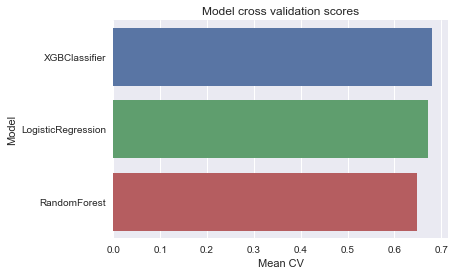

In [167]:
# Convert list of models to a pandas dataframe
chart_df = pd.DataFrame([vars(m) for m in models])
chart_df = chart_df.sort_values("mean_cv_score", ascending=False)

# Draw chart
chart = sns.barplot("mean_cv_score", "name", data = chart_df, orient = "h")
chart.set_xlabel("Mean CV")
chart.set_ylabel("Model")
chart.set_title("Model cross validation scores")

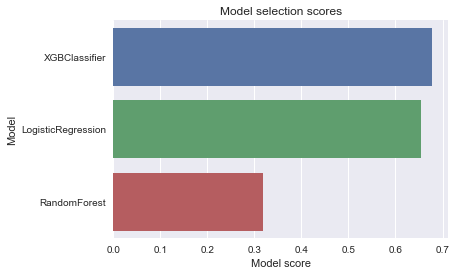

In [168]:
# Evaluate best models by penalising models that overfit
for model in models:
    model.model_score = model.mean_cv_score - (model.training_score - model.mean_cv_score)

# Convert list of models to a pandas dataframe
chart_df = pd.DataFrame([vars(m) for m in models])
chart_df = chart_df.sort_values("model_score", ascending=False)

# Draw chart
chart = sns.barplot("model_score", "name", data = chart_df, orient = "h")
chart.set_xlabel("Model score")
chart.set_ylabel("Model")
chart.set_title("Model selection scores")

In [169]:
for model in models:
    model.predictions = model.model.predict_proba(X_test)[:, 0]
    print(model.predictions)
#     print(model.predictions)


[ 0.76305706  0.62922207  0.26070208 ...,  0.20599503  0.16705681
  0.67985469]
[ 0.7  0.2  0.3 ...,  0.2  0.   0.7]
[ 0.68807203  0.70647031  0.27160561 ...,  0.30114549  0.27013564
  0.50897288]


# Save predictions

In [170]:
model_df = pd.DataFrame([vars(m) for m in models])
model_df = model_df.sort_values("model_score", ascending=False)

model_weight = len(model_df)
prediction_values = []
prediction_scores = []

for index, row in model_df.iterrows():
    weight = 0.1 * model_weight
    model_weight -= 1
    prediction_values.append(row["predictions"])
    prediction_scores.append(row["model_score"] * weight)
    
prediction_weights = np.array(prediction_scores) / sum(prediction_scores)
prediction_weights

predictions = 0.

for i in range(len(prediction_weights)):
    predictions += prediction_weights[i] * prediction_values[i]
    
# print(models[0].model.predict_proba(X))
submission = pd.DataFrame({ "shot_id": test_data[id_column] })
submission[y_column] = predictions

submission.to_csv("_dave_submit.csv", index=False)